# A High-entropy Introduction to Pytorch

**Important**: You **must** install Pytorch in your Anaconda environment for this laboratory. The easiest way to do this is to just install the CPU version of Pytorch like this:

```
conda activate FML
conda install -c pytorch pytorch torchvision
```

**Note**: If you have an Nvidia GPU on your computer you can also install the GPU-enabled version of Pytorch which will **greatly** improve performance for more complex models and larger datasets. However, it can be very hard to get all of the versions of the required libraries to match correctly... During the laboratory we can look at it together if you are interested.

After installing Pytorch, use the next cell to verify that the installation is working. If it prints a 3x3 sensor, we're good to go.

In [20]:
# We will still need numpy for some things.
import numpy as np
import matplotlib.pyplot as plt
import math

# This is the main torch namespace.
import torch



if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")
    
if torch.cuda.is_available() == True:
    cuda_device = torch.device("cuda")


print(torch.backends.mps.is_available()) #the MacOS is higher than 12.3+
print(torch.backends.mps.is_built()) #MPS is activated

print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device:{torch.cuda.current_device()}")
print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")



# If this works, things should be OK.
print(torch.randn((3, 3)))

MPS device not found.
False
False
Is CUDA supported by this system? True
CUDA version: 11.8
ID of current CUDA device:0
Name of current CUDA device:NVIDIA GeForce RTX 4060 Ti
tensor([[-0.1134, -1.7416, -0.4202],
        [-1.2587,  1.3379,  0.3826],
        [-1.7320,  0.4196,  1.4883]])


In this notebook and accompanying video I will barely scratch the surface of what Pytorch is and what it can do. Please see the excellent [Introduction to Pytorch](https://pytorch.org/tutorials/beginner/introyt.html) series on YouTube for more details.

In [21]:
x = torch.randint(1, 100, (100, 100))

# Checking the device name:
# Should return 'cpu' by default
print(x.device)

# Applying tensor operation
res_cpu = x ** 2

# Transferring tensor to GPU
x = x.to(torch.device('cuda'))

# Checking the device name:
# Should return 'cuda:0'
print(x.device)

# Applying same tensor operation
res_gpu = x ** 2

# Checking the equality
# of the two results
assert torch.equal(res_cpu, res_gpu.cpu())

cpu
cuda:0


## Simple Gradient Descent in Pytorch

All computations done with pytorch "live" in a computational graph. This is transparent to us, until... it *isn't*. Let's just say it takes some getting used to.

We will reproduce an early example of gradient descent using pytorch. We will find the minimum of a translated parabola. First let's see how to build the computational graph for a parabolic function.

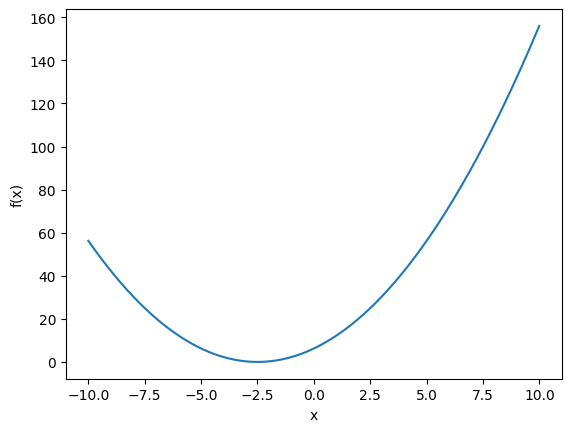

In [22]:
# This is the definition of our translated parabola. Note that this is *identical*
# to how we would define this in numpy.
def tpara(x, t=0):
    return (x+t)**2

# Plot the parabola over a range of values.
rng = np.arange(-10, +10, 0.01)
plt.plot(rng, [tpara(x, 2.5) for x in rng])
_ = [plt.xlabel('x'), plt.ylabel('f(x)')]

OK, but what about **pytorch** in all of this?! Well, if we call the function with **pytorch tensors** instead of constant values, we will construct a **computational graph** of the parabola function instead of actually performing the computation.

Let's see how we can build graphs and perform calculations with them.

In [23]:
# Instantiate an input (and prepare it for computing gradient).
x = torch.randn((1,), requires_grad=True)

# Build the graph representing the computation of the parabola.
foo = tpara(x, 2.5)

# Inspect the output.
print(f' Input  (a tensor): {x}')
print(f' Output (a tensor): {foo}')
print(f'Duplicating output: {(x.item() + 2.5)**2}')  # The item() method returns the value of a 0-degree (scalar) tensor.

 Input  (a tensor): tensor([0.1884], requires_grad=True)
 Output (a tensor): tensor([7.2277], grad_fn=<PowBackward0>)
Duplicating output: 7.227693823009551


Now let's plot the parabola using the pytorch implementation.

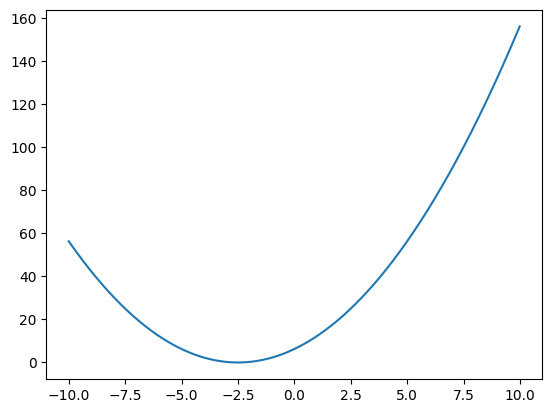

In [24]:
# Note the use of item() here and how we *must* pass a tensor in input.
plt.plot(rng, [tpara(torch.tensor(x, requires_grad=True).item(), 2.5) for x in rng])

## Finding the minimum.

OK, so what? This just seems like the same functionality of the numpy version but with extra steps. Well, the whole reason to use pytorch (or any graph-based numerical programming framework) is the facilitate the computation of **gradients**. Let's compute the derivative of our parabola with respect to $x$. In particular, as we all know:

$$ \frac{d}{dx} (x+c)^{2} = 2(x+c). $$

Let's compute this numerically for specific values of $x$ and $c$:

In [25]:
# Use a specific x and c.
x = torch.tensor([3.0], requires_grad=True)
t = 1.34

# Forward pass, then backward pass to compute gradient.
foo = tpara(x, t)
foo.backward()

# Is it correct?
print(f'Computed gradient: {x.grad}')
print(f'    True gradient: {2*(x.item() + t)}')

Computed gradient: tensor([8.6800])
    True gradient: 8.68


OK, now we can implement gradient descent to find the minimum of our function:

In [26]:
# Start at some random point, fix a translation t.
x = torch.randn((), requires_grad=True, dtype=torch.float32)
t = 7.5

# Iterate gradient steps for a fixed number of updates.
points = []
for i in range(20):
    # Need to *zero* the gradient before every iteration!
    if x.grad:
        x.grad.zero_()
    
    # The forward and backward passes.
    current = tpara(x, t)
    current.backward()
    
    # Save the current value for plotting.
    points.append((x.item(), current.item()))
    
    # And make the gradient step -- we need the no_grad() otherwise
    # we *add* this operation to the graph!
    with torch.no_grad():
        x -= 0.9 * x.grad


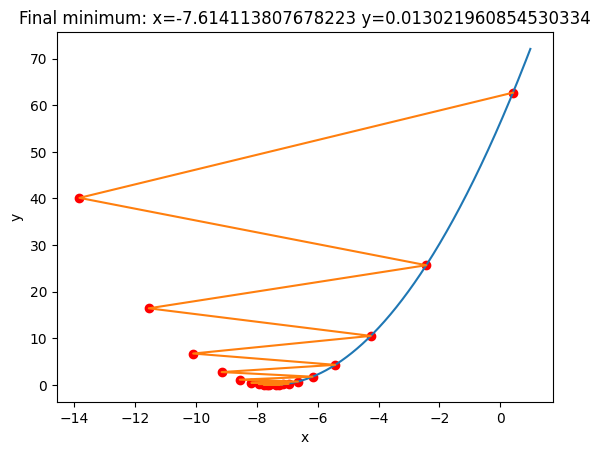

In [27]:
# Plot the results.
rng = np.arange(-7.6, 1.0, 0.01) 
plt.plot(rng, [tpara(torch.tensor(x, requires_grad=True).item(), t) for x in rng])
plt.scatter([x for (x, _) in points], [y for (_, y) in points], c='red')
plt.plot([x for (x, _) in points], [y for (_, y) in points])
plt.xlabel('x')
plt.ylabel('y')
_ = plt.title(f'Final minimum: x={points[-1][0]} y={points[-1][1]}')

## Deep Linear Regression in Pytorch

OK, enough dinking around... Let's build a deep network for solving a linear regression problem. When working with Deep Learning we usually we don't build the network tensor by tensor. Instead we will use the tools provided by pytorch specifically for working with deep models.

First, let's setup the regression problem just like we did way back in the first lectures of the course a sinusoidal function that we sample from **with noise**.

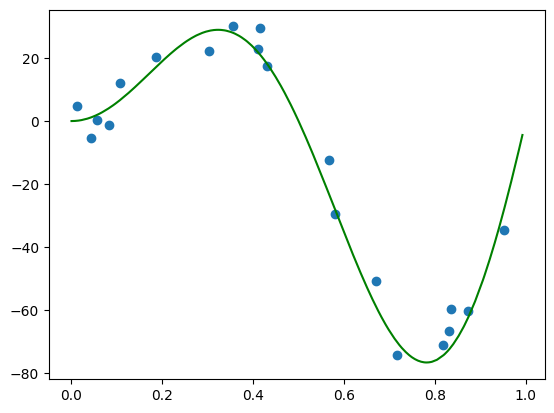

In [28]:
# Standard imports for numerical programming.
import numpy as np
import matplotlib.pyplot as plt

# The true function -- that is, what we want to estimate from data.
def true_fn(x):
    return 100 * x*np.sin(2*np.pi*x)

# The observation process: true + Gaussian Noise.
def observed_fn(x, beta):
    noise = np.random.normal(0, 1, size=x.shape) * beta(x)
    return true_fn(x) + noise

# How we actually observe a function: uniformly generate N random
# xs in rng, apply the passed function to the xs.
def sample_from_fn(fn, N, rng=[0.0, 1.0]):
    xs = np.sort(np.random.random(size=(N,)) * (rng[1]-rng[0]) + rng[0])
    return (xs, fn(xs))

# Sample 300 points from the true function and plot them (in green).
(true_xs, true_fxs) = sample_from_fn(true_fn, 300)
plt.plot(true_xs, true_fxs, 'g')

# Now sample 20 points from the observed function and plot
# the samples (in blue).
(observed_xs, observed_fxs) = sample_from_fn(lambda x: observed_fn(x, beta=lambda x: 1/0.2), 20)
_ = plt.scatter(observed_xs, observed_fxs)

Now we will define our model. However, since we generated all of our data with numpy we **must** first convert it to pytorch tensors before we can work with it. This is one of the main stubling blocks with pytorch -- converting data back and forth between pytorch and numpy arrays.

In [29]:
# Pytorch imports.
import torch

# Convert our dataset to pytorch tensors.
t_observed_xs  = torch.tensor(observed_xs.reshape(len(observed_xs), 1), dtype=torch.float32)
t_observed_fxs = torch.tensor(observed_fxs.reshape(len(observed_fxs), 1), dtype=torch.float32)

As mentioned above, we will make extensive use of the `torch.nn` namespace. It contains a **ton** of functionality for defining layers in Deep Neural Networks. In particular we are using:

+ `torch.nn.Sequential`: Which defines a model that consists of sequential application of one or more computational layers.
+ `torch.nn.Linear`: Our good old linear layer, in this case one that takes an input of size 1 and produces an output of size 1. This is just our old friend Linear Regression.

In [30]:
# Define our model, starting with simple linear regression (no hidden layers).
model = torch.nn.Sequential(
    torch.nn.Linear(1, 1)
)

Now we can train the model with gradient descent. Note that we are using **batch gradient descent** here -- we compute the loss over the *entire* dataset to then compute the gradient.

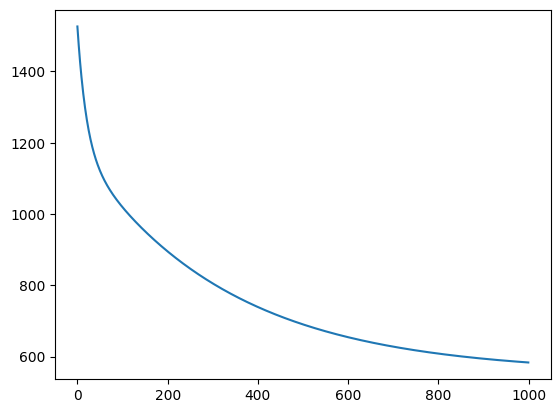

In [31]:
# Training hyperparameters.
epochs = 1000
learning_rate = 1e-2

# The gradient descent training loop.
losses = []
for epoch in range(epochs):
    # Erase previous gradients.
    model.zero_grad()
    
    # Forward pass (plus loss).
    output = model(t_observed_xs)
    loss = torch.nn.functional.mse_loss(output, t_observed_fxs)
    
    # Backpropagate gradients.
    loss.backward()
    
    # And perform gradient descent.
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

    # Save the current loss for later.
    losses.append(loss.detach().numpy())
            
# And plot the losses.
_ = plt.plot(losses)

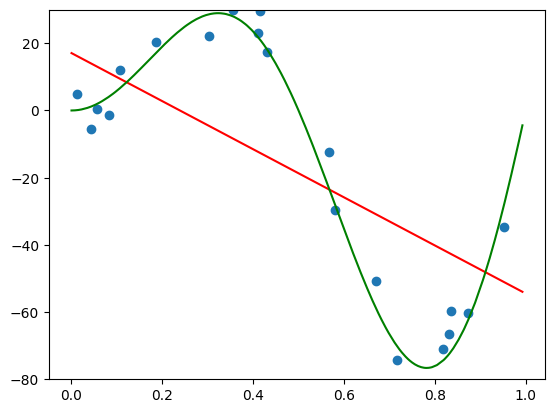

In [32]:
# And plot our polynomial estimate.
predictions = model(torch.tensor(true_xs.reshape(len(true_xs), 1), dtype=torch.float32)).detach().numpy()
plt.plot(true_xs, predictions, 'r')
plt.scatter(observed_xs, observed_fxs)
plt.plot(true_xs, true_fxs, 'g')
_ = plt.ylim([-80, 30])

## Going Deeper

OK, well that worked about as well as we knew it would. Let's train a deep model with hidden layer and see if we can do better. I will take this opportunity to encapsulate *some* of the training functionality and to produce an animation of the training. The deep network we will use two hidden layers of 100 units.

**Note**: This cell takes a long time to compute, and the animation functionality of Matplotlib is *very* primitive.

Using device: cuda
Model transferred to cuda


KeyboardInterrupt: 

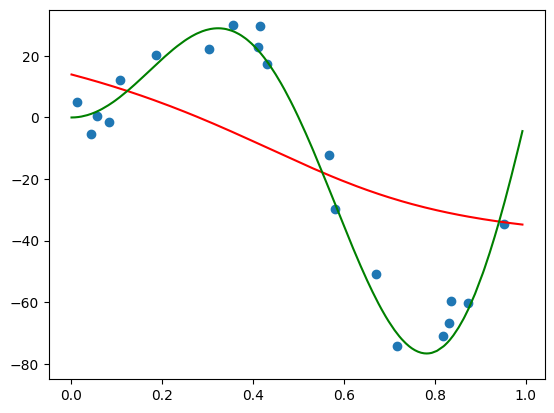

In [38]:
from matplotlib import animation
import matplotlib
import torchvision.models as models

matplotlib.rcParams['animation.embed_limit'] = 2**128

# Making the code device-agnostic
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

# Transferring the model to a CUDA enabled GPU
model = model.to(device)
print(f'Model transferred to {device}')



# Define a fresh model.
model = torch.nn.Sequential(
    torch.nn.Linear(1, 100),
    torch.nn.Tanh(),
    torch.nn.Linear(100, 100),
    torch.nn.Tanh(),
    torch.nn.Linear(100, 1)
)



# Setup the basic plot.
(fig, ax) = plt.subplots()
predictions = model(torch.tensor(true_xs.reshape(len(true_xs), 1), dtype=torch.float32)).detach().numpy()
regressor, = ax.plot(true_xs, predictions, 'r')
ax.plot(true_xs, true_fxs, 'g')
ax.scatter(observed_xs, observed_fxs)
ax.set_ylim([-85, 35])

# This should be in a class to encapsulate everything better.
losses = []
def update():
    # Erase previous gradients.
    model.zero_grad()
    
    # Forward pass (plus loss).
    output = model(t_observed_xs)
    loss = torch.nn.functional.mse_loss(output, t_observed_fxs)
    
    # Backpropagate gradients.
    loss.backward()
    
    # And perform gradient descent.
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad
    return model(torch.tensor(true_xs.reshape(len(true_xs), 1), dtype=torch.float32)).detach().numpy()

def iterate(i, learning_rate, model):
    regressor.set_data(true_xs, update())
    return [regressor]

# Training hyperparameters.
epochs = 5000
learning_rate = 1e-3

# And animate!
foo = animation.FuncAnimation(fig, lambda i: iterate(i, learning_rate, model), frames=epochs, interval=10, blit=True)
from IPython.display import HTML
HTML(foo.to_jshtml())

## Caveats and Disclaimers

This notebook provides a **minimal** introduction to the important concepts and ways of using Pytorch. That said, we **NEVER** implement our own gradient descent training looks as shown in these examples. Well, almost never... We will be using the optimizers provided in the [torch.optim](https://pytorch.org/docs/stable/optim.html) package which wraps Stochastic Gradient Descent with all of the bells and whistles to train real models.

Using device: cuda
Model transferred to cuda


KeyboardInterrupt: 

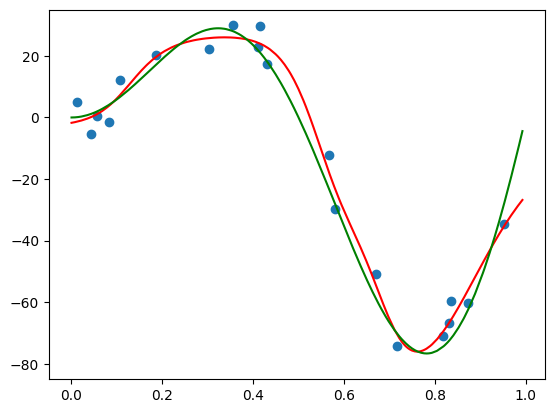

In [39]:
from IPython.display import HTML
import torch
from matplotlib import animation
import matplotlib.pyplot as plt
import torchvision.models as models

matplotlib.rcParams['animation.embed_limit'] = 2**128

# Making the code device-agnostic
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

# Define a fresh model.
model = torch.nn.Sequential(
    torch.nn.Linear(1, 100),
    torch.nn.Tanh(),
    torch.nn.Linear(100, 100),
    torch.nn.Tanh(),
    torch.nn.Linear(100, 1)
)

# Transferring the model to a CUDA enabled GPU
model = model.to(device)
print(f'Model transferred to {device}')

# Setup the basic plot.
(fig, ax) = plt.subplots()
predictions = model(torch.tensor(true_xs.reshape(
    len(true_xs), 1), dtype=torch.float32).to(device)).cpu().detach().numpy()
regressor, = ax.plot(true_xs, predictions, 'r')
ax.plot(true_xs, true_fxs, 'g')
ax.scatter(observed_xs, observed_fxs)
ax.set_ylim([-85, 35])

# This should be in a class to encapsulate everything better.
losses = []


def update():
    # Erase previous gradients.
    model.zero_grad()

    # Forward pass (plus loss).
    output = model(t_observed_xs.to(device))
    loss = torch.nn.functional.mse_loss(output, t_observed_fxs.to(device))

    # Backpropagate gradients.
    loss.backward()

    # And perform gradient descent.
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad
    return model(torch.tensor(true_xs.reshape(len(true_xs), 1), dtype=torch.float32).to(device)).cpu().detach().numpy()


def iterate(i, learning_rate, model):
    regressor.set_data(true_xs, update())
    return [regressor]


# Training hyperparameters.
epochs = 5000
learning_rate = 1e-3

# And animate!
foo = animation.FuncAnimation(fig, lambda i: iterate(
    i, learning_rate, model), frames=epochs, interval=10, blit=True)
HTML(foo.to_jshtml())